In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [21]:
def add_noise(img, noise_factor=0.1):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    noisy_img = torch.clip(noisy_img, 0., 1.)  # Ограничиваем значения в пределах [0, 1]
    return noisy_img

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [9]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=64):
        super(DenoisingAutoencoder, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)


In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        
        # Добавляем шум к изображениям
        noisy_data = add_noise(data)

        optimizer.zero_grad()
        outputs = model(noisy_data)
        loss = criterion(outputs, data)  # Сравниваем с чистыми изображениями
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.0590
Epoch [2/10], Loss: 0.0371
Epoch [3/10], Loss: 0.0317
Epoch [4/10], Loss: 0.0293
Epoch [5/10], Loss: 0.0277
Epoch [6/10], Loss: 0.0265
Epoch [7/10], Loss: 0.0256
Epoch [8/10], Loss: 0.0249
Epoch [9/10], Loss: 0.0243
Epoch [10/10], Loss: 0.0239


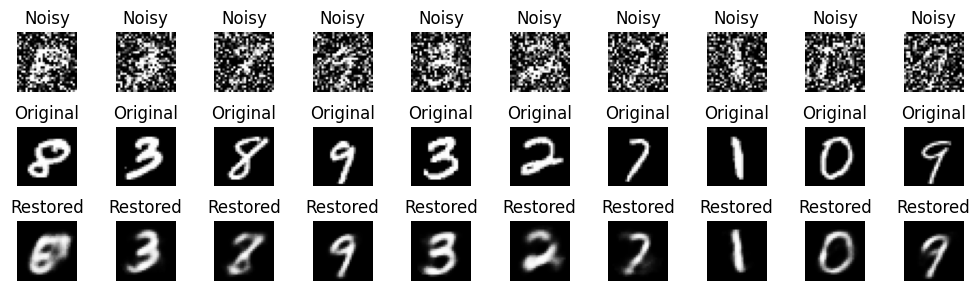

In [12]:
def visualize_denoising(model, dataloader, device, num_samples=10):
    model.eval()
    noisy_images = []
    clean_images = []
    restored_images = []

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            
            # Добавляем шум
            noisy_data = add_noise(data)
            
            # Получаем восстановленные изображения
            restored = model(noisy_data)
            
            # Собираем изображения для визуализации
            noisy_images.append(noisy_data.cpu())
            clean_images.append(data.cpu())
            restored_images.append(restored.cpu())

            if len(noisy_images) * len(data) >= num_samples:
                break

    # Печатаем первые num_samples
    noisy_images = torch.cat(noisy_images, dim=0)[:num_samples]
    clean_images = torch.cat(clean_images, dim=0)[:num_samples]
    restored_images = torch.cat(restored_images, dim=0)[:num_samples]

    # Визуализация
    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples, 3))
    
    for i in range(num_samples):
        axes[0, i].imshow(noisy_images[i].view(28, 28), cmap='gray')
        axes[0, i].set_title("Noisy")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(clean_images[i].view(28, 28), cmap='gray')
        axes[1, i].set_title("Original")
        axes[1, i].axis('off')
        
        axes[2, i].imshow(restored_images[i].view(28, 28), cmap='gray')
        axes[2, i].set_title("Restored")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Визуализация
visualize_denoising(model, train_loader, device)


In [24]:
img, _ = train_dataset[4]
img = img.view(-1).to(device) 
noisy_img = add_noise(img).to(device)

model.eval()  # Переводим модель в режим оценки
with torch.no_grad():
    reconstructed_img = model(noisy_img.unsqueeze(0))  # Делаем прогноз для зашумленного изображения

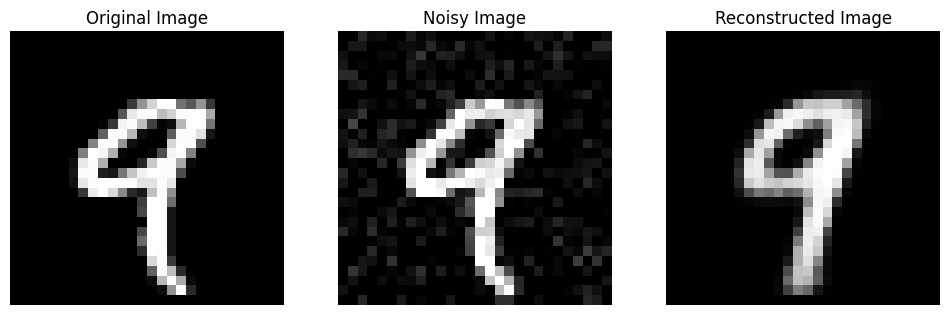

In [26]:
# Визуализируем результаты
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Оригинальное изображение
axs[0].imshow(img.cpu().view(28, 28).numpy(), cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

# Зашумленное изображение
axs[1].imshow(noisy_img.cpu().view(28, 28).numpy(), cmap='gray')
axs[1].set_title("Noisy Image")
axs[1].axis('off')

# Восстановленное изображение
axs[2].imshow(reconstructed_img.cpu().view(28, 28).numpy(), cmap='gray')
axs[2].set_title("Reconstructed Image")
axs[2].axis('off')

plt.show()